# TF 2.0, Keras

In [1]:
import tensorflow as tf;
print(tf.__version__)

/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

2.0.0-beta1


In [2]:
import keras

Using TensorFlow backend.


In [3]:
# to generate gifs
# !pip install imageio

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x  # Colab only.
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as k

# for one hot encoding seqence input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

from IPython import display

import os
import pickle
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

In [5]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

In [7]:
path = '/home/jupyter/CU/fold/data/35k/'

In [8]:
cd /home/jupyter/CU/fold/data/35k/

/home/jupyter/CU/fold/data/35k


In [9]:
def load_dcalpha_ss_pssm_data(frag_size):
    """
    Loads tuple of dcalpha matrices, ss arrays, and pssms into numpy nd arrays
    Output dcalpha ndarray of shape (num_examples, frag_size, frag_size, 1)
    """
    
    dcalphas = np.array([])
    seqs = np.array([])
    pssms = np.array([])
    m_frags = []
    s_frags = []
    p_frags = []
    all_pdbs = []
    foldlist = [3, 20, 63, 73]
    #for fold in range(1,50): # Full dataset is 75 folds
    for fold in foldlist:
        #fold = 3
        path = 'training_100_{}.pkl'.format(fold)
        data = pickle.load(open(path, 'rb'))
        pdbs = list(data.keys())
        all_pdbs += pdbs
        
        for p in pdbs:
            full_matrix = np.array(data[p]['dcalpha'])
            full_seq = np.array(data[p]['aa']) # amino acid sequence
            full_pssm = np.array(data[p]['pssm']) # pssm
            
            num_bonds = full_matrix.shape[0]
            
            # get non-overlapping fragments of frag_size length
            if (full_matrix.shape[0] >= frag_size):
                idx = 0
                for i in range(frag_size, num_bonds, frag_size):
                    matrix_frag = full_matrix[idx:i, idx:i]
                    seq_frag = full_seq[()][idx:i]
                    pssm_frag = full_pssm[:, idx:i]
                    
                    idx = i # update start index
                    m_frags.append(matrix_frag)
                    s_frags.append(seq_frag)
                    p_frags.append(pssm_frag)
                    
            num_loaded=len(m_frags)
        print("fold {} complete, so far loaded {} pairwise matrices of size {}".format(fold, num_loaded, frag_size))
    
    dcalphas = np.stack(m_frags)
    
    # one hot encode the sequences
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(s_frags)
    int_seq = tokenizer.texts_to_sequences(s_frags)
    s_frags = to_categorical(int_seq)
    
    seqs = np.stack(s_frags)
    pssms = np.stack(p_frags)
    
    dcalphas = dcalphas.reshape(dcalphas.shape[0], frag_size, frag_size, 1).astype('float32')
    seqs = seqs.reshape(seqs.shape[0], 128, 21, 1).astype('float32')
    # TODO reshape the pssms into the right format
    
    print(dcalphas.shape)
    print(seqs.shape)
    print(pssms.shape)
    print(len(pdbs))
    
    return dcalphas, seqs, pssms, all_pdbs

In [10]:
training_maps, seqs, pssms, pdbs = load_dcalpha_ss_pssm_data(128)

# normalize...(downscale by factor of 100)
training_maps = training_maps/np.max(training_maps)#100

fold 3 complete, so far loaded 336 pairwise matrices of size 128
fold 20 complete, so far loaded 749 pairwise matrices of size 128
fold 63 complete, so far loaded 1076 pairwise matrices of size 128
fold 73 complete, so far loaded 1517 pairwise matrices of size 128
(1517, 128, 128, 1)
(1517, 128, 21, 1)
(1517, 21, 128)
363


In [397]:
train_dataset = training_maps[0:1000,:,:,:]
train_seqs = seqs[0:1000]
test_dataset = training_maps[1000:1500,:,:,:]
test_seqs = seqs[1000:1500]
TRAIN_BUF = 1000
BATCH_SIZE = 100

TEST_BUF = 500

train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [352]:
class functionalCVAE():
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim
        self.inference_net = self.inference_net()
        self.generative_net = self.generative_net()
        self.trainables = self.generative_net.trainable_variables + self.inference_net.trainable_variables
        
    def inference_net(self):
        in_mat = layers.Input(shape=(128,128,1))
        mat = layers.Conv2D(64, (4,4), strides=(2,2), activation='relu')(in_mat)
        mat = layers.Conv2D(32, (4,4), strides=(2,2), activation='relu')(mat)
        mat = layers.Flatten()(mat)
        output = layers.Dense(self.latent_dim + self.latent_dim)(mat)
        model = Model(inputs=[in_mat], outputs=[output])
        #opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.5, beta_2=0.999)
       #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model
    
    def generative_net(self):
        """ Generative Net """
        # Decode conditional information
        in_seq = layers.Input(shape=(None,128,21,1))
        seq = layers.Flatten()(in_seq)
        seq = layers.Dense(units=32*32*128, use_bias=False)(seq)
        seq = layers.reshape(target_shape=(32,32,128))(seq)
        
        # Decode latent states
        in_latent = layers.Input(shape=(None, self.latent_dim))
        latent = layers.Dense(units=32*32*128, activation=tf.nn.relu)(in_latent)
        latent = layers.Reshape(target_shape=(32, 32, 128))(latent)
        merge = layers.Concatenate()([latent, seq])
        
        gen = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(merge)
        gen = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu')(latent)
        # No activation
        output = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")(latent)
        model = Model([in_latent, in_seq], output)
        return model
        
    """
    def generative_net(self):
        #in_seq = layers.Input(shape=(None,128,21,1))
        #seq = layers.Flatten()(in_seq)
        #seq = layers.Dense(4*4*512, use_bias=False)(seq)
        #seq = layers.Reshape((4,4,512))(seq)
        
        # input latent
        in_latent = layers.Input(shape=(None,self.latent_dim))
        latent = layers.Dense(4*4*512, use_bias=False)(in_latent)
        latent = layers.Reshape((4,4,512))(latent)
        #merge = layers.Concatenate()([latent, seq])
        merge = layers.Concatenate()([latent, latent])
        
        gen = layers.Conv2DTranspose(512, (4,4), strides=(1,1), padding='same', use_bias=False)(merge)
        gen = layers.BatchNormalization()(gen)
        gen = layers.LeakyReLU()(gen)
        
        gen = layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', use_bias=False)(gen)
        gen = layers.BatchNormalization()(gen)
        gen = layers.LeakyReLU()(gen)
        
        gen = layers.Conv2DTranspose(128, (4,4), strides=(4,4), padding='same', use_bias=False)(gen)
        gen = layers.BatchNormalization()(gen)
        gen = layers.LeakyReLU()(gen)
        
        gen = layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', use_bias=False)(gen)
        gen = layers.BatchNormalization()(gen)
        gen = layers.LeakyReLU()(gen)
        
        output = layers.Conv2DTranspose(1, (4,4), strides=(2,2), padding='same', use_bias=False, activation='sigmoid')(gen)
        #model = Model([in_latent, in_seq], output)
        model=Model([in_latent], output)
        
        # add optimizer and compile
        #opt = tf.keras.optimizers.Adam(lr=1e-3, beta_1=0.65, beta_2=0.999)
        #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        
        return model
    """
    
    @tf.function
    def sample(self, seq, eps=None):
        # Takes as input a random latent encoding and passes it through the decoder
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode([eps,seq], apply_sigmoid=True)
    
    def encode(self,x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self,z, apply_sigmoid=False):
        logits = self.generative_net(z)#(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    
                

## Initialize Model

In [343]:
myCVAE = functionalCVAE(100)

6

## Test Functions (No Conditioning)

In [ ]:
#len(myCVAE.generative_net.trainable_variables)
#len(myCVAE.inference_net.trainable_variables)
#varz = myCVAE.generative_net.trainable_variables + myCVAE.inference_net.trainable_variables
#len(varz)
#myCVAE.trainables
#myCVAE.inference_net.trainable_variables

In [344]:
#mu, var = myCVAE.encode(np.random.randn(3,128,128,1).astype(np.float32))
#decoded_images = myCVAE.decode([np.random.randn(3,100)])
#myCVAE.decode(myCVAE.encode((np.random.randn(3,128,128,1).astype(np.float32))))
#myCVAE.sample([np.random.randn(3,100)]).shape
#myCVAE.sample(myCVAE.encode(np.random.randn(3,128,128,1).astype(np.float32))).shape

TensorShape([3, 128, 128, 1])

In [383]:
#myCVAE.decode([np.random.randn(3,100), np.random.randn(3,128,21,1)])
#myCVAE.sample([np.random.randn(3,100), np.random.randn(3,128,21,1)]).shape

TensorShape([3, 128, 128, 1])

In [406]:
optimizer = tf.keras.optimizers.Adam(1e-3)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

@tf.function
def compute_loss(model, x, seq):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode([z, seq])
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, seq, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, seq)
    #gradients = tape.gradient(loss, model.trainable_variables)
    gradients = tape.gradient(loss, model.trainables)
    #optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    optimizer.apply_gradients(zip(gradients, model.trainables))

In [407]:
epochs = 100
latent_dim = 100
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
fixed_seqs = train_seqs[0:num_examples_to_generate]

In [408]:
def generate_and_save_images(model, epoch, test_input, test_seq):
    predictions = model.sample([test_input, test_seq])
    fig = plt.figure(figsize=(8,8))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='winter')
        plt.axis('off')
        
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

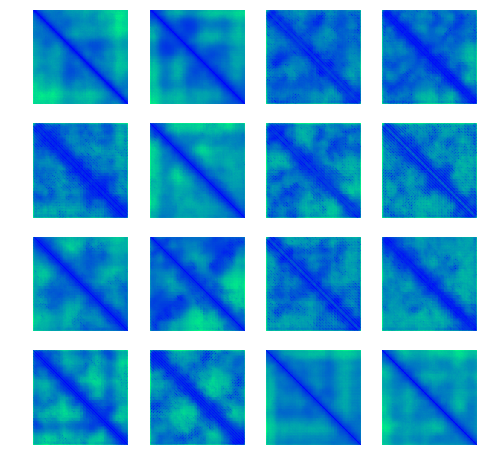

In [409]:
generate_and_save_images(myCVAE, 0, random_vector_for_generation, fixed_seqs)

In [412]:
#myloss = compute_loss(myCVAE,training_maps[0:10],np.random.randn(10,128,21,1))
#myloss

## Train this puppy...

Epoch: 35, Test set ELBO: -5733.9775390625, time elapse for current epoch 8.016127109527588


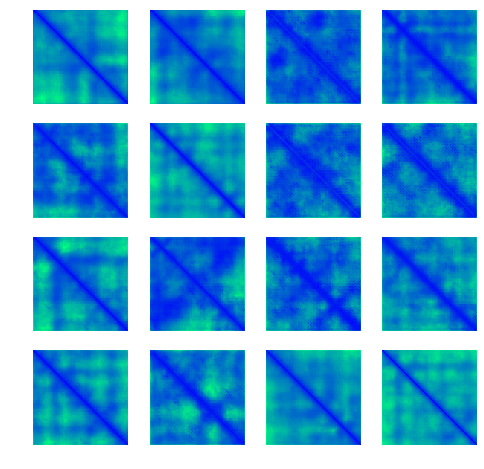

In [ ]:
generate_and_save_images(myCVAE, 0, random_vector_for_generation, fixed_seqs)

for epoch in range(1, epochs + 1):
    print("Fly baby, fly...")
    start_time = time.time()
    #for train_x in train_dataset:
    for train_x, seq_x in zip(train_dataset, train_seqs):
        compute_apply_gradients(myCVAE, train_x, seq_x, optimizer)
    end_time = time.time()
    
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        #for test_x in test_dataset:
        for test_x, seq_x in zip(test_dataset, test_seqs):
            loss(compute_loss(myCVAE, test_x, seq_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, ' 'time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))
        generate_and_save_images(myCVAE, epoch, random_vector_for_generation, train_seqs[0:num_examples_to_generate])

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
plt.imshow(display_image(epochs))
plt.axis('off')# Display images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)